Load required packages

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

plt.style.use('seaborn-white')
%matplotlib inline

Some plotting functions to help you plot the ROC curve

In [2]:
# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' for house price > 200,000', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')


Load the Sacramento housing data

In [3]:
sac = pd.read_csv('../assets/datasets/Sacramentorealestatetransactions.csv')

Create a binary variable where 1 indicates a house sold for over 200,000 and 0 indicates a house sold for equal to or less than 200,000.

Subset the data to just contain the number of beds, baths, the sq ft, and the over 200k indicator variable.

In [4]:
sac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
street       985 non-null object
city         985 non-null object
zip          985 non-null int64
state        985 non-null object
beds         985 non-null int64
baths        985 non-null int64
sq__ft       985 non-null int64
type         985 non-null object
sale_date    985 non-null object
price        985 non-null int64
latitude     985 non-null float64
longitude    985 non-null float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.4+ KB


In [11]:
sac['over200'] = 1
sac.loc[sac['price'] <= 200000, 'over200'] = 0
sac['over200'].unique()
cols = ['beds', 'baths', 'sq__ft', 'over200']
sub = sac[cols]
sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 986 entries, 0 to over200
Data columns (total 4 columns):
beds       986 non-null int64
baths      986 non-null int64
sq__ft     986 non-null int64
over200    986 non-null int64
dtypes: int64(4)
memory usage: 38.5+ KB


Split your data into training and testing sets. The predictors are the beds, baths, and sq ft. The feature is the over 200k class variable. Make the test size 33% (and optionally stratify by the over 200k class).

Fit a logistic regression on the training data.

Print out the confusion matrix

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(sub[['beds', 'baths', 'sq__ft']], sub[['over200']].values, 
                                                    test_size=0.33, random_state=77)

logreg = LogisticRegression(random_state=77)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

conmat = np.array(confusion_matrix(Y_test, Y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['over_200k', 'under_200k'],
                         columns=['predicted_over_200k','predicted_under_200k'])

print(confusion)


            predicted_over_200k  predicted_under_200k
over_200k                   141                    49
under_200k                   76                    60


Calculate the accuracy, precision, and recall. What can these three metrics tell you about your model?

In [20]:
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.55      0.44      0.49       136
          1       0.65      0.74      0.69       190

avg / total       0.61      0.62      0.61       326



Say as a real estate agent, I prioritize minimizing false positives (predicting a house will sell for over 200k when it actually sells for under) because false positives make me lose money.

Change the decision threshold to **lower the false positive rate** and then print out the new confusion matrix. What is the downside to lowering the false positive rate?

In [36]:
Y_pp = pd.DataFrame(logreg.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
print(Y_pp.iloc[0:10])
print(len(X_test), len(Y_pp))
Y_pp['pred_class_thresh50'] = Y_pred
print(Y_pp.iloc[0:10])
Y_pp['pred_class_thresh10'] = [1 if x >= 0.6 else 0 for x in Y_pp.class_1_pp.values]
print(Y_pp.iloc[0:10])


conmat_10 = np.array(confusion_matrix(Y_test, Y_pp.pred_class_thresh10.values, labels=[1,0]))

confusion_10 = pd.DataFrame(conmat_10, index=['over_200k', 'under_200k'],
                         columns=['predicted_over_200knewThresh','predicted_under_200knewThresh'])

print(classification_report(Y_test, Y_pred))
print(classification_report(Y_test, Y_pp.pred_class_thresh10.values))
print(confusion)
print(confusion_10)

   class_0_pp  class_1_pp
0    0.277275    0.722725
1    0.745636    0.254364
2    0.432987    0.567013
3    0.419277    0.580723
4    0.457138    0.542862
5    0.588796    0.411204
6    0.459574    0.540426
7    0.420429    0.579571
8    0.607468    0.392532
9    0.492306    0.507694
(326, 326)
   class_0_pp  class_1_pp  pred_class_thresh50
0    0.277275    0.722725                    1
1    0.745636    0.254364                    0
2    0.432987    0.567013                    1
3    0.419277    0.580723                    1
4    0.457138    0.542862                    1
5    0.588796    0.411204                    0
6    0.459574    0.540426                    1
7    0.420429    0.579571                    1
8    0.607468    0.392532                    0
9    0.492306    0.507694                    1
   class_0_pp  class_1_pp  pred_class_thresh50  pred_class_thresh10
0    0.277275    0.722725                    1                    1
1    0.745636    0.254364                    0    

Plot the ROC curve using the plotting function provided.

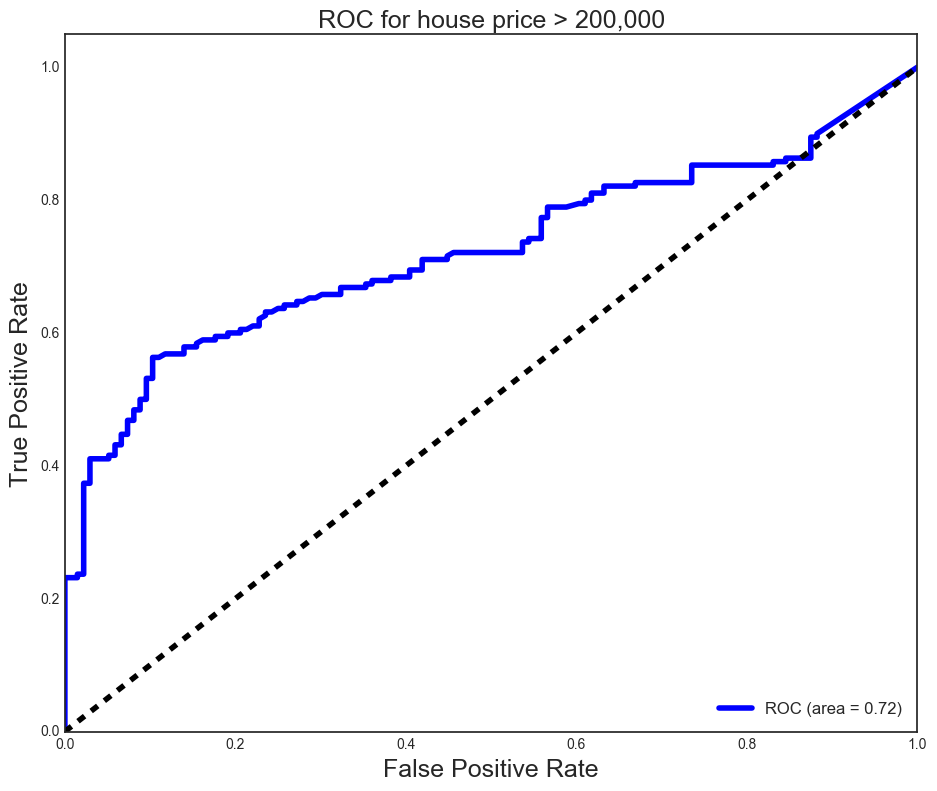

In [29]:
Y_score = logreg.decision_function(X_test)
plot_roc(Y_test, Y_score)

Bonus: when might precision and recall be more useful than the ROC?

Precision and recall are more useful when the proportion of the positive class is smaller, since they are sensitive to this.